<a href="https://colab.research.google.com/github/SupermarketAutomationAI/PrimaryModel_1/blob/main/primary_model_JX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Data - V1

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/SupermarketAutomationAI_Dataset_V1' -d '/root/datasets'

Split the data

In [ ]:
# Import the necessary libraries
import json
import os
import math
import shutil

In [ ]:
# create data directory and move all images into it
parent_dir = "/root/datasets/SupermarketAutomationAI_Dataset_V1"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

In [ ]:
train_split = 0.6

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
 path = parent_dir + '/'+ dsdirs
 os.mkdir( path,755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)
    
    # TODO: Print number of files in directory, and compute the actual split porportions
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    src_files = len(files)
    print("SRC - {} : {} files".format(category, src_files))
    os.chdir(train_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    train_files = len(files)
    print("TRAIN - {} : {} files".format(category, train_files))
    os.chdir(val_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    val_files = len(files)
    print("VAL - {} : {} files".format(category, val_files))
    os.chdir(test_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    test_files = len(files)
    print("TEST - {} : {} files".format(category, test_files))

    total_files = train_files + val_files + test_files
    print("Split: {}% training, {}% validation, and {}% test".format((train_files/total_files * 100), (val_files/total_files * 100), (test_files/total_files * 100)))

SRC - One Banana : 0 files
TRAIN - One Banana : 313 files
VAL - One Banana : 103 files
TEST - One Banana : 104 files
Split: 60.192307692307686% training, 19.807692307692307% validation, and 20.0% test
SRC - One Golden Delicious Apple : 0 files
TRAIN - One Golden Delicious Apple : 667 files
VAL - One Golden Delicious Apple : 221 files
TEST - One Golden Delicious Apple : 222 files
Split: 60.09009009009009% training, 19.90990990990991% validation, and 20.0% test
SRC - One Gala Apple : 0 files
TRAIN - One Gala Apple : 531 files
VAL - One Gala Apple : 175 files
TEST - One Gala Apple : 176 files
Split: 60.204081632653065% training, 19.841269841269842% validation, and 19.954648526077097% test
SRC - Multiple Golden Delicious Apples : 0 files
TRAIN - Multiple Golden Delicious Apples : 1771 files
VAL - Multiple Golden Delicious Apples : 589 files
TEST - Multiple Golden Delicious Apples : 590 files
Split: 60.03389830508474% training, 19.966101694915253% validation, and 20.0% test
SRC - Multiple F

In [ ]:
# Remove hidden files & directories that break data loader
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  !find $path -name '._*' -delete
  print("Deleted ._* files from {0}".format(path))

Deleted ._* files from /root/datasets/SupermarketAutomationAI_Dataset_V1/train
Deleted ._* files from /root/datasets/SupermarketAutomationAI_Dataset_V1/val
Deleted ._* files from /root/datasets/SupermarketAutomationAI_Dataset_V1/test


# Using AlexNet for feature extraction

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models

In [ ]:
# List different classes: 14 currently
classes = ['Multiple Bananas', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Golden Delicious Apples', 
           'Multiple Granny Smith Apples', 'Multiple Oranges', 'Multiple Red Delicious Apples',
           'One Banana', 'One Fuji Apple', 'One Gala Apple', 'One Golden Delicious Apple',
           'One Granny Smith Apple', 'One Orange', 'One Red Delicious Apple']

In [ ]:
# Get pretrained weights from the internet
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
def get_relevant_indices(dataset, classes, target_classes):
  '''
  Return the indices for datapoints in the dataset that belongs to the desired
  target classes
  '''
  indices = []
  for i in range(len(dataset)):
    # Check if the label is in the target class
    label_index = dataset[i][1]
    label_class = classes[label_index]
    if label_class in target_classes:
      indices.append(i)
  return indices

In [ ]:
# Assumptions:
# - resize to 224 by 224
def get_alexnet_features(path, classes, target_classes, verify=False):
  '''
  Loads the images from the datasets folder and computes the AlexNet features
  then save those computed features
  '''
  start_time = time.time()
  # transform settings
  transform = transforms.Compose([transforms.Resize((224,224)), 
                                  transforms.ToTensor()])
  
  # load data from given path, data is already split into 3 folders
  train_dataset = torchvision.datasets.ImageFolder(path + '/train', transform=transform)
  val_dataset = torchvision.datasets.ImageFolder(path + '/val', transform=transform)
  test_dataset = torchvision.datasets.ImageFolder(path + '/test', transform=transform)

  # load data with batch size of 1 since each image needs to be saved 1 at a time
  batch_size = 1
  num_workers = 1
  train_sampler = SubsetRandomSampler(get_relevant_indices(train_dataset, classes, target_classes))
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(get_relevant_indices(val_dataset, classes, target_classes))
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(get_relevant_indices(test_dataset, classes, target_classes))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=test_sampler)

  # save features to folders as tensors
  ###TRAIN###
  if os.path.exists(path + '/train/features'):
    # may contain old data
    shutil.rmtree(path + '/train/features')
    print("Found /train/features exists, removed.")

  n = 0
  fig = plt.figure(figsize=(32, 4)) #for verify later on
  print("Saving training data features...")
  for img, label in train_loader: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/train/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

    if verify is True and n <= 20:
      # verification step
      image = img.numpy() #convert to numpy for display
      ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
      plt.imshow(np.transpose(image[0], (1, 2, 0)))
      ax.set_title(classes[label[0]])

  ###VALIDATION###
  if os.path.exists(path + '/val/features'):
    # may contain old data
    shutil.rmtree(path + '/val/features')
    print("Found /val/features exists, removed.")

  n=0
  print("Saving validation data features...")
  for img, label in val_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/val/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
  
  ###TEST###
  if os.path.exists(path + '/test/features'):
    # may contain old data
    shutil.rmtree(path + '/test/features')
    print("Found /test/features exists, removed.")

  n=0
  print("Saving test data features...")
  for img, label in val_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/test/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
  
  end_time = time.time()
  print("Total time:  % 6.2f s" % ( end_time-start_time))
  return

In [ ]:
# List all directories because there seems to be a lot of hidden directories
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  stuff = os.listdir(path)
  print(stuff)
  !find $path -name '.*' -delete

['One Banana', 'One Golden Delicious Apple', 'One Gala Apple', 'Multiple Golden Delicious Apples', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Granny Smith Apples', 'One Red Delicious Apple', 'Multiple Red Delicious Apples', 'One Granny Smith Apple', 'Multiple Bananas', 'One Fuji Apple', 'One Orange', 'Multiple Oranges']
['One Banana', 'One Golden Delicious Apple', 'One Gala Apple', 'Multiple Golden Delicious Apples', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Granny Smith Apples', 'One Red Delicious Apple', 'Multiple Red Delicious Apples', 'One Granny Smith Apple', 'Multiple Bananas', 'One Fuji Apple', 'One Orange', 'Multiple Oranges']
['One Banana', 'One Golden Delicious Apple', 'One Gala Apple', 'Multiple Golden Delicious Apples', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Granny Smith Apples', 'One Red Delicious Apple', 'Multiple Red Delicious Apples', 'One Granny Smith Apple', 'Multiple Bananas', 'One Fuji Apple', 'One Orange', 'Multiple

Saving training data features...
Saving validation data features...
Saving test data features...
Total time:   139.70 s


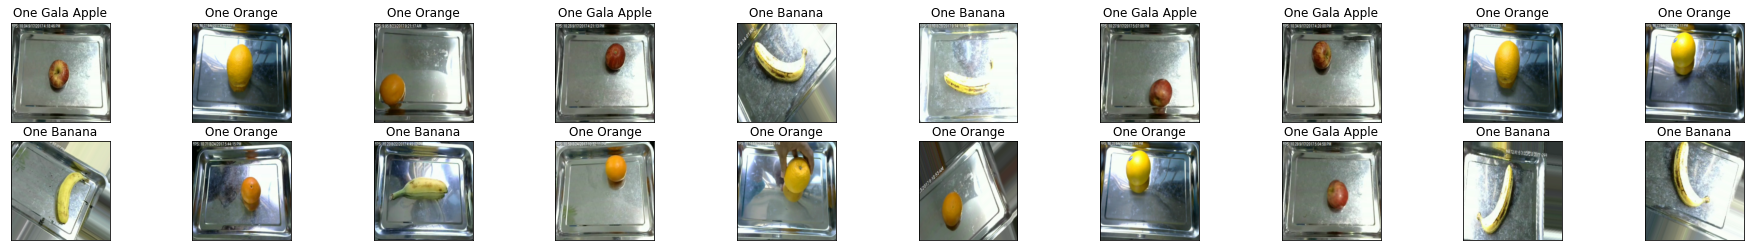

In [ ]:
target_classes = ['One Orange', 'One Gala Apple', 'One Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

In [ ]:
def get_feature_loader(path, batch_size=32):
    '''
    Loads saved tensor files with features extracted using AlexNet
    '''
    # load tensor files from folder
    train_dataset = torchvision.datasets.DatasetFolder(path + '/train/features/', loader=torch.load, extensions=('.tensor'))
    val_dataset = torchvision.datasets.DatasetFolder(path + '/val/features/', loader=torch.load, extensions=('.tensor'))
    test_dataset = torchvision.datasets.DatasetFolder(path + '/test/features/', loader=torch.load, extensions=('.tensor'))

    # Prepare Dataloader
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

    # Verification Step - obtain one batch of features
    data_iter = iter(train_loader)
    features, labels = data_iter.next()
    print("Training Shape:")
    print(features.shape)
    print(labels.shape)

    data_iter = iter(val_loader)
    features, labels = data_iter.next()
    print("Validation Shape:")
    print(features.shape)
    print(labels.shape)

    data_iter = iter(test_loader)
    features, labels = data_iter.next()
    print("Test Shape:")
    print(features.shape)
    print(labels.shape)
    print('\n')

    return train_loader, val_loader, test_loader

In [ ]:
# Load saved AlexNet features, batch size 64
train_loader, val_loader, test_loader = get_feature_loader(parent_dir, batch_size=64)

Training Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])
Validation Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])
Test Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])




# CNN Model Architecture

Architecture:

Start with 1 convolution and 1 pooling layer then a FC layer

In [ ]:
torch.manual_seed(1) # set the random seed

class AlexNetCNNClassifier(nn.Module):
    def __init__(self):
        super(AlexNetCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(256, 50, 3) # creates 4x4 feature map
        self.pool = nn.MaxPool2d(2, 2) # createst 2x2 feature map
        self.fc1 = nn.Linear(50*2*2, 15) # <<<<<< output 14 classes but with 14 it errors out...

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 50*2*2)
        x = self.fc1(x)
        return x

In [ ]:
def get_accuracy_AlexNet(model, data_loader, use_cuda=False):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_AlexNet(model, train_loader, val_loader, num_epochs=1, batch_size=32, learn_rate=0.001, use_cuda=False):
    # Note train_loader = feature_loader

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    iters, train_acc, val_acc = [], [], []

    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):

        for imgs, labels in iter(train_loader):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)       # forward pass, imgs already the features extracted from AlexNet
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        iters.append(n)
        train_acc.append(get_accuracy_AlexNet(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy_AlexNet(model, val_loader))  # compute validation accuracy
        print("Epoch {0} | Training Accuracy: {1} | Validation Accuracy: {2}".format(epoch + 1, train_acc[-1], val_acc[-1]))

    end_time= time.time()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Tune Hyperparameter with All Datasets

Saving training data features...
Saving validation data features...
Saving test data features...
Total time:   525.07 s


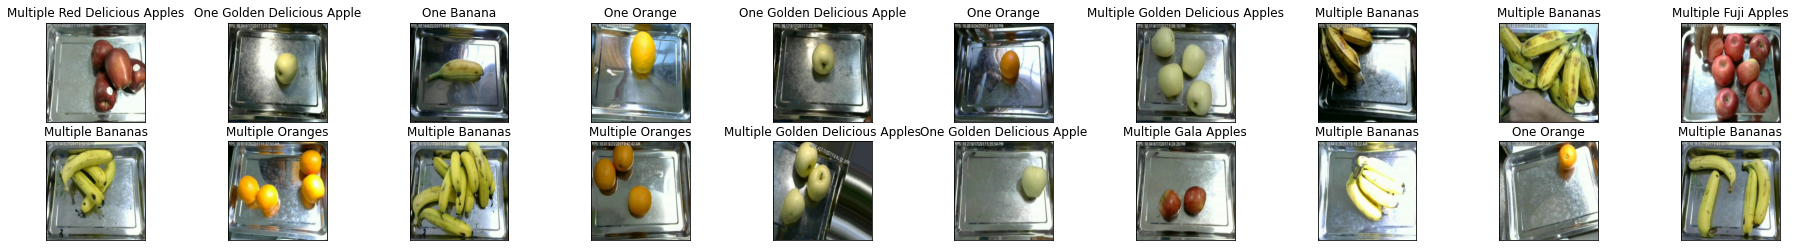

In [ ]:
target_classes = classes
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Training Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])
Validation Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])
Test Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])


Training Started...
Epoch 1 | Training Accuracy: 0.9785364448285797 | Validation Accuracy: 0.9730094466936572
Epoch 2 | Training Accuracy: 0.991212906943244 | Validation Accuracy: 0.9842555105713
Epoch 3 | Training Accuracy: 0.9943820224719101 | Validation Accuracy: 0.9856050382366172
Epoch 4 | Training Accuracy: 0.9958225295303947 | Validation Accuracy: 0.9802069275753487
Epoch 5 | Training Accuracy: 0.9933736675309709 | Validation Accuracy: 0.9815564552406658
Epoch 6 | Training Accuracy: 0.9933736675309709 | Validation Accuracy: 0.9824561403508771
Epoch 7 | Training Accuracy: 0.9975511380005762 | Validation Accuracy: 0.9806567701304544
Epoch 8 | Training Accuracy: 0.9989916450590608 | Validation Accuracy: 0.9883040935672515
Epoch 9 | Training Accuracy: 0.9900605012964564 | Validation Accuracy: 0.96851102

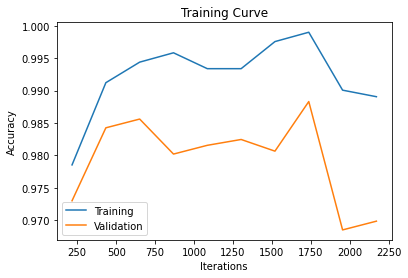

Final Training Accuracy: 0.9890521463555172
Final Validation Accuracy: 0.9698605488079173
Total time:   122.33 s  Time per Epoch:  12.23 s 


In [ ]:
class AlexNetCNNClassifier_3(nn.Module):
    def __init__(self):
        super(AlexNetCNNClassifier_3, self).__init__()
        self.conv1 = nn.Conv2d(256, 128, 3) # creates 4x4 feature map
        self.pool = nn.MaxPool2d(2, 2) # createst 2x2 feature map
        self.fc1 = nn.Linear(128*2*2, 14) # <<<<<< output 14 classes but with 14 it errors out...

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 128*2*2)
        x = self.fc1(x)
        return x
model = AlexNetCNNClassifier_3()
train_loader, val_loader, test_loader = get_feature_loader(parent_dir, batch_size=32) # reload AlexNet features with new batch_size
train_AlexNet(model, train_loader, val_loader, batch_size=32, num_epochs=10)

# Past Results

Second Model Test (with smaller subset)

Found /train/features exists, removed.
Saving training data features...
Found /val/features exists, removed.
Saving validation data features...
Found /test/features exists, removed.
Saving test data features...
Total time:   314.59 s


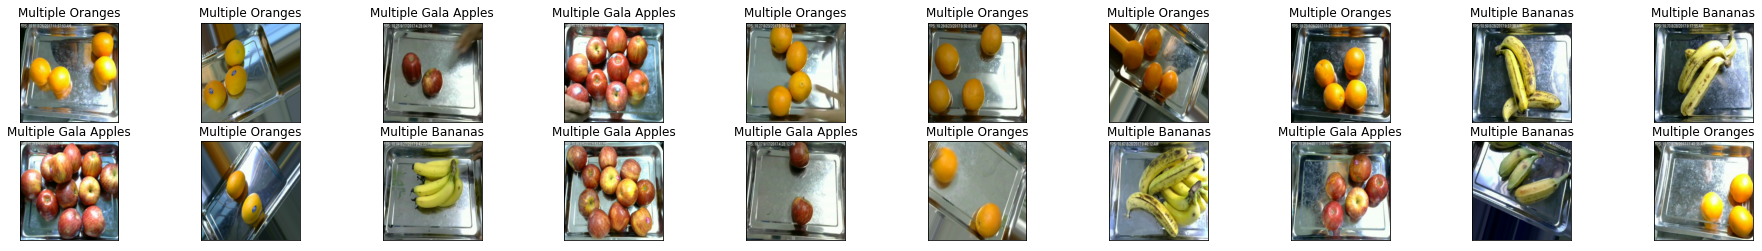

In [ ]:
target_classes = ['Multiple Oranges', 'Multiple Gala Apples', 'Multiple Bananas']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Training Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])
Validation Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])
Test Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])


Training Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 | Training Accuracy: 0.9994287346472437 | Validation Accuracy: 1.0
Epoch 2 | Training Accuracy: 0.9997143673236218 | Validation Accuracy: 1.0
Epoch 3 | Training Accuracy: 1.0 | Validation Accuracy: 0.9991341991341991
Epoch 4 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch 5 | Training Accuracy: 1.0 | Validation Accuracy: 0.9991341991341991
Epoch 6 | Training Accuracy: 1.0 | Validation Accuracy: 0.9991341991341991
Epoch 7 | Training Accuracy: 1.0 | Validation Accuracy: 0.9991341991341991
Epoch 8 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch 9 | Training Accuracy: 1.0 | Validation Accuracy: 0.9991341991341991
Epoch 10 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch 11 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch 12 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch 13 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch 14 | Training Accuracy: 1.0 | Validation Accuracy: 0.9991341991341991
Epoch 15 | Training Accuracy: 1.0 |

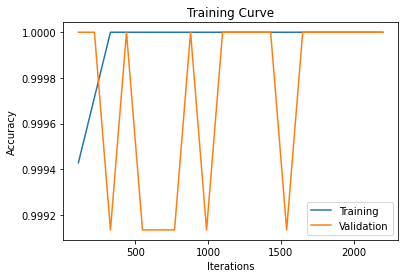

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0
Total time:   72.70 s  Time per Epoch:   3.64 s 


In [ ]:
# New model
torch.manual_seed(1) # set the random seed

class AlexNetCNNClassifier_2(nn.Module):
    def __init__(self):
        super(AlexNetCNNClassifier_2, self).__init__()
        self.conv1 = nn.Conv2d(256, 50, 3) # creates 4x4 feature map
        self.pool = nn.MaxPool2d(2, 2) # createst 2x2 feature map
        self.fc1 = nn.Linear(50*2*2, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 50*2*2)
        x = self.fc1(x)
        return x

model = AlexNetCNNClassifier_2()
train_loader, val_loader, test_loader = get_feature_loader(parent_dir, batch_size=32) # reload AlexNet features with new batch_size
train_AlexNet(model, train_loader, val_loader, batch_size=32, num_epochs=20)

First Model Test

Training Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])
Validation Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])
Test Shape:
torch.Size([32, 256, 6, 6])
torch.Size([32])


Training Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 | Training Accuracy: 0.4430344442894994 | Validation Accuracy: 0.004761904761904762
Epoch 2 | Training Accuracy: 0.4448473016315716 | Validation Accuracy: 0.0030303030303030303
Epoch 3 | Training Accuracy: 0.4450564774787338 | Validation Accuracy: 0.003463203463203463
Epoch 4 | Training Accuracy: 0.44338307070143634 | Validation Accuracy: 0.0021645021645021645
Epoch 5 | Training Accuracy: 0.4450564774787338 | Validation Accuracy: 0.0008658008658008658
Epoch 6 | Training Accuracy: 0.44631153256170686 | Validation Accuracy: 0.0008658008658008658
Epoch 7 | Training Accuracy: 0.444568400502022 | Validation Accuracy: 0.0012987012987012987
Epoch 8 | Training Accuracy: 0.4446381257844094 | Validation Accuracy: 0.0012987012987012987
Epoch 9 | Training Accuracy: 0.4424069167480128 | Validation Accuracy: 0.010822510822510822
Epoch 10 | Training Accuracy: 0.44561427973783296 | Validation Accuracy: 0.0025974025974025974
Epoch 11 | Training Accuracy: 0.4461720819969321 | Validation Accuracy

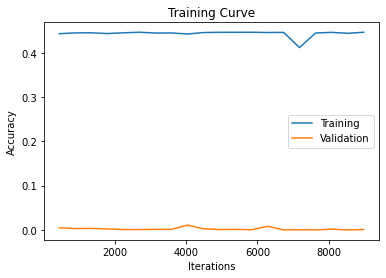

Final Training Accuracy: 0.4462418072793195
Final Validation Accuracy: 0.0008658008658008658
Total time:   326.65 s  Time per Epoch:  16.33 s 


In [ ]:
# Initial model with all datasets (multiple and single fruit in each image as well as all the different apple varieties)
model = AlexNetCNNClassifier()
train_loader, val_loader, test_loader = get_feature_loader(parent_dir, batch_size=32) # reload AlexNet features with new batch_size
train_AlexNet(model, train_loader, val_loader, batch_size=32, num_epochs=20)